Primero tenemos que importar el dataset CelebA en nuestro entorno de trabajo. Tendremos que tener el dataset en esa carpeta dentro de tu drive.

In [3]:
from shutil import copyfile
from google.colab import drive
import os, sys
# GUARDAR FICEHROS EN DRIVE Y LUEGO MONTAR DRIVE EN COLAB Y PONER EL PATH DONDE ESTAN LOS FICHEROS
drive.mount('/content/drive')
copyfile('/content/drive/My Drive/GANS/archive.zip', './archive.zip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'./archive.zip'

In [4]:
%cd '/content/drive/My Drive/GANS'

/content/drive/My Drive/GANS


In [5]:
import shutil
shutil.copy2('archive.zip', '/content/')

'/content/archive.zip'

In [6]:
%cd ".."
%cd ".."
%cd ".."

/content/drive/My Drive
/content/drive
/content


In [7]:
# Unzip the dataset
!unzip -q archive.zip
# Remove the zip file
!rm archive.zip

Esta es nuestra arquitectura de las redes.

In [8]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


# test()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt

In [10]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 7
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

cuda


In [11]:
transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [12]:
dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
# initialize gen and disc/critic
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [14]:
# initializate optimizer
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs_WGAN/real")
writer_fake = SummaryWriter(f"logs_WGAN/fake")
step = 0

gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [15]:
losses_critic = []
losses_gen = []

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (data, _) in enumerate(tqdm(loader)):
        data = data.to(device)

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Append losses to the lists
        losses_critic.append(loss_critic.item())
        losses_gen.append(loss_gen.item())

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    data[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

  3%|▎         | 100/3166 [01:16<39:39,  1.29it/s]

Epoch [0/7] Batch 100/3166                   Loss D: -1.5062, loss G: 0.7112


  6%|▋         | 201/3166 [02:32<39:10,  1.26it/s]

Epoch [0/7] Batch 200/3166                   Loss D: -1.5203, loss G: 0.7153


 10%|▉         | 301/3166 [03:46<37:43,  1.27it/s]

Epoch [0/7] Batch 300/3166                   Loss D: -1.5251, loss G: 0.7167


 13%|█▎        | 401/3166 [05:01<36:07,  1.28it/s]

Epoch [0/7] Batch 400/3166                   Loss D: -1.5288, loss G: 0.7173


 16%|█▌        | 501/3166 [06:15<34:50,  1.27it/s]

Epoch [0/7] Batch 500/3166                   Loss D: -1.5277, loss G: 0.7175


 19%|█▉        | 600/3166 [07:29<32:12,  1.33it/s]

Epoch [0/7] Batch 600/3166                   Loss D: -1.5277, loss G: 0.7172


 22%|██▏       | 700/3166 [08:45<30:57,  1.33it/s]

Epoch [0/7] Batch 700/3166                   Loss D: -1.5294, loss G: 0.7173


 25%|██▌       | 801/3166 [10:00<31:34,  1.25it/s]

Epoch [0/7] Batch 800/3166                   Loss D: -1.5301, loss G: 0.7171


 28%|██▊       | 901/3166 [11:15<29:38,  1.27it/s]

Epoch [0/7] Batch 900/3166                   Loss D: -1.5294, loss G: 0.7167


 32%|███▏      | 1001/3166 [12:29<28:29,  1.27it/s]

Epoch [0/7] Batch 1000/3166                   Loss D: -1.5270, loss G: 0.7157


 35%|███▍      | 1101/3166 [13:43<27:11,  1.27it/s]

Epoch [0/7] Batch 1100/3166                   Loss D: -1.5255, loss G: 0.7162


 38%|███▊      | 1201/3166 [14:58<26:08,  1.25it/s]

Epoch [0/7] Batch 1200/3166                   Loss D: -1.5042, loss G: 0.7070


 41%|████      | 1301/3166 [16:13<25:04,  1.24it/s]

Epoch [0/7] Batch 1300/3166                   Loss D: -1.5085, loss G: 0.7095


 44%|████▍     | 1401/3166 [17:27<22:57,  1.28it/s]

Epoch [0/7] Batch 1400/3166                   Loss D: -1.4964, loss G: 0.6964


 47%|████▋     | 1501/3166 [18:41<21:44,  1.28it/s]

Epoch [0/7] Batch 1500/3166                   Loss D: -1.5048, loss G: 0.7097


 51%|█████     | 1601/3166 [19:56<20:51,  1.25it/s]

Epoch [0/7] Batch 1600/3166                   Loss D: -1.4943, loss G: 0.7070


 54%|█████▎    | 1701/3166 [21:10<19:29,  1.25it/s]

Epoch [0/7] Batch 1700/3166                   Loss D: -1.4605, loss G: 0.6923


 57%|█████▋    | 1801/3166 [22:25<17:54,  1.27it/s]

Epoch [0/7] Batch 1800/3166                   Loss D: -1.4219, loss G: 0.6756


 60%|██████    | 1900/3166 [23:38<15:38,  1.35it/s]

Epoch [0/7] Batch 1900/3166                   Loss D: -1.4514, loss G: 0.6911


 63%|██████▎   | 2001/3166 [24:54<15:35,  1.24it/s]

Epoch [0/7] Batch 2000/3166                   Loss D: -1.3966, loss G: 0.6707


 66%|██████▋   | 2101/3166 [26:08<14:08,  1.26it/s]

Epoch [0/7] Batch 2100/3166                   Loss D: -1.3506, loss G: 0.6482


 70%|██████▉   | 2201/3166 [27:23<12:30,  1.29it/s]

Epoch [0/7] Batch 2200/3166                   Loss D: -1.2529, loss G: 0.5984


 73%|███████▎  | 2301/3166 [28:37<11:29,  1.25it/s]

Epoch [0/7] Batch 2300/3166                   Loss D: -1.2474, loss G: 0.5622


 76%|███████▌  | 2400/3166 [29:51<09:22,  1.36it/s]

Epoch [0/7] Batch 2400/3166                   Loss D: -1.2126, loss G: 0.5812


 79%|███████▉  | 2501/3166 [31:06<08:53,  1.25it/s]

Epoch [0/7] Batch 2500/3166                   Loss D: -1.2873, loss G: 0.6140


 82%|████████▏ | 2601/3166 [32:20<07:20,  1.28it/s]

Epoch [0/7] Batch 2600/3166                   Loss D: -1.2120, loss G: 0.6223


 85%|████████▌ | 2701/3166 [33:35<06:03,  1.28it/s]

Epoch [0/7] Batch 2700/3166                   Loss D: -1.2089, loss G: 0.6529


 88%|████████▊ | 2801/3166 [34:49<04:45,  1.28it/s]

Epoch [0/7] Batch 2800/3166                   Loss D: -1.2206, loss G: 0.5781


 92%|█████████▏| 2900/3166 [36:03<03:19,  1.33it/s]

Epoch [0/7] Batch 2900/3166                   Loss D: -1.1489, loss G: 0.4558


 95%|█████████▍| 3001/3166 [37:18<02:10,  1.27it/s]

Epoch [0/7] Batch 3000/3166                   Loss D: -1.1295, loss G: 0.4774


 98%|█████████▊| 3101/3166 [38:33<00:50,  1.28it/s]

Epoch [0/7] Batch 3100/3166                   Loss D: -0.6150, loss G: 0.6416


  3%|▎         | 101/3166 [01:15<41:35,  1.23it/s]

Epoch [1/7] Batch 100/3166                   Loss D: -1.1348, loss G: 0.6269


  6%|▋         | 201/3166 [02:29<39:02,  1.27it/s]

Epoch [1/7] Batch 200/3166                   Loss D: -1.1344, loss G: 0.5682


 10%|▉         | 301/3166 [03:44<37:17,  1.28it/s]

Epoch [1/7] Batch 300/3166                   Loss D: -1.1928, loss G: 0.5777


 13%|█▎        | 401/3166 [04:58<35:43,  1.29it/s]

Epoch [1/7] Batch 400/3166                   Loss D: -1.1379, loss G: 0.5638


 16%|█▌        | 500/3166 [06:11<33:05,  1.34it/s]

Epoch [1/7] Batch 500/3166                   Loss D: -1.1624, loss G: 0.5536


 19%|█▉        | 601/3166 [07:26<33:42,  1.27it/s]

Epoch [1/7] Batch 600/3166                   Loss D: -1.1461, loss G: 0.5401


 22%|██▏       | 701/3166 [08:40<32:03,  1.28it/s]

Epoch [1/7] Batch 700/3166                   Loss D: -1.0165, loss G: 0.2893


 25%|██▌       | 801/3166 [09:54<30:41,  1.28it/s]

Epoch [1/7] Batch 800/3166                   Loss D: -1.1026, loss G: 0.4653


 28%|██▊       | 901/3166 [11:08<30:13,  1.25it/s]

Epoch [1/7] Batch 900/3166                   Loss D: -1.1745, loss G: 0.5689


 32%|███▏      | 1001/3166 [12:23<28:50,  1.25it/s]

Epoch [1/7] Batch 1000/3166                   Loss D: -1.0857, loss G: 0.5106


 35%|███▍      | 1101/3166 [13:37<27:00,  1.27it/s]

Epoch [1/7] Batch 1100/3166                   Loss D: -1.1739, loss G: 0.5700


 38%|███▊      | 1201/3166 [14:51<25:32,  1.28it/s]

Epoch [1/7] Batch 1200/3166                   Loss D: -1.0562, loss G: 0.4845


 41%|████      | 1301/3166 [16:05<24:19,  1.28it/s]

Epoch [1/7] Batch 1300/3166                   Loss D: -0.9465, loss G: 0.6129


 44%|████▍     | 1400/3166 [17:19<21:59,  1.34it/s]

Epoch [1/7] Batch 1400/3166                   Loss D: -1.0665, loss G: 0.6019


 47%|████▋     | 1501/3166 [18:34<22:02,  1.26it/s]

Epoch [1/7] Batch 1500/3166                   Loss D: -0.9680, loss G: 0.6109


 51%|█████     | 1601/3166 [19:48<20:23,  1.28it/s]

Epoch [1/7] Batch 1600/3166                   Loss D: -0.8234, loss G: 0.6063


 54%|█████▎    | 1701/3166 [21:02<19:05,  1.28it/s]

Epoch [1/7] Batch 1700/3166                   Loss D: -1.0283, loss G: 0.4525


 57%|█████▋    | 1800/3166 [22:16<16:48,  1.35it/s]

Epoch [1/7] Batch 1800/3166                   Loss D: -1.0731, loss G: 0.5721


 60%|██████    | 1901/3166 [23:31<17:01,  1.24it/s]

Epoch [1/7] Batch 1900/3166                   Loss D: -1.0264, loss G: 0.5384


 63%|██████▎   | 2001/3166 [24:45<15:18,  1.27it/s]

Epoch [1/7] Batch 2000/3166                   Loss D: -1.0619, loss G: 0.5000


 66%|██████▋   | 2100/3166 [25:59<12:59,  1.37it/s]

Epoch [1/7] Batch 2100/3166                   Loss D: -0.9559, loss G: 0.5842


 69%|██████▉   | 2200/3166 [27:13<11:44,  1.37it/s]

Epoch [1/7] Batch 2200/3166                   Loss D: -1.0150, loss G: 0.4712


 73%|███████▎  | 2301/3166 [28:29<11:37,  1.24it/s]

Epoch [1/7] Batch 2300/3166                   Loss D: -0.9500, loss G: 0.4106


 76%|███████▌  | 2401/3166 [29:43<10:02,  1.27it/s]

Epoch [1/7] Batch 2400/3166                   Loss D: -1.0191, loss G: 0.5279


 79%|███████▉  | 2501/3166 [30:57<08:36,  1.29it/s]

Epoch [1/7] Batch 2500/3166                   Loss D: -1.0389, loss G: 0.5489


 82%|████████▏ | 2601/3166 [32:11<07:19,  1.29it/s]

Epoch [1/7] Batch 2600/3166                   Loss D: -0.9571, loss G: 0.3833


 85%|████████▌ | 2701/3166 [33:25<06:12,  1.25it/s]

Epoch [1/7] Batch 2700/3166                   Loss D: -0.9859, loss G: 0.5711


 88%|████████▊ | 2801/3166 [34:40<04:51,  1.25it/s]

Epoch [1/7] Batch 2800/3166                   Loss D: -0.9738, loss G: 0.5286


 92%|█████████▏| 2901/3166 [35:54<03:26,  1.28it/s]

Epoch [1/7] Batch 2900/3166                   Loss D: -0.8678, loss G: 0.3410


 95%|█████████▍| 3001/3166 [37:09<02:09,  1.28it/s]

Epoch [1/7] Batch 3000/3166                   Loss D: -0.9520, loss G: 0.5693


 98%|█████████▊| 3101/3166 [38:23<00:50,  1.28it/s]

Epoch [1/7] Batch 3100/3166                   Loss D: -0.8758, loss G: 0.3220


  3%|▎         | 101/3166 [01:14<39:52,  1.28it/s]

Epoch [2/7] Batch 100/3166                   Loss D: -0.9169, loss G: 0.4128


  6%|▋         | 201/3166 [02:29<38:23,  1.29it/s]

Epoch [2/7] Batch 200/3166                   Loss D: -0.9705, loss G: 0.4411


 10%|▉         | 301/3166 [03:43<37:32,  1.27it/s]

Epoch [2/7] Batch 300/3166                   Loss D: -0.9392, loss G: 0.3892


 13%|█▎        | 400/3166 [04:57<34:48,  1.32it/s]

Epoch [2/7] Batch 400/3166                   Loss D: -0.9203, loss G: 0.5600


 16%|█▌        | 501/3166 [06:12<34:46,  1.28it/s]

Epoch [2/7] Batch 500/3166                   Loss D: -0.9369, loss G: 0.5401


 19%|█▉        | 601/3166 [07:27<33:32,  1.27it/s]

Epoch [2/7] Batch 600/3166                   Loss D: -0.8054, loss G: 0.5665


 22%|██▏       | 701/3166 [08:41<31:55,  1.29it/s]

Epoch [2/7] Batch 700/3166                   Loss D: -0.8790, loss G: 0.3449


 25%|██▌       | 801/3166 [09:55<30:50,  1.28it/s]

Epoch [2/7] Batch 800/3166                   Loss D: -0.8891, loss G: 0.3979


 28%|██▊       | 900/3166 [11:09<28:10,  1.34it/s]

Epoch [2/7] Batch 900/3166                   Loss D: -0.7590, loss G: 0.5381


 32%|███▏      | 1001/3166 [12:24<28:34,  1.26it/s]

Epoch [2/7] Batch 1000/3166                   Loss D: -0.6494, loss G: 0.5017


 35%|███▍      | 1101/3166 [13:38<27:04,  1.27it/s]

Epoch [2/7] Batch 1100/3166                   Loss D: -0.8622, loss G: 0.5111


 38%|███▊      | 1201/3166 [14:52<25:36,  1.28it/s]

Epoch [2/7] Batch 1200/3166                   Loss D: -0.8208, loss G: 0.5338


 41%|████      | 1301/3166 [16:07<24:23,  1.27it/s]

Epoch [2/7] Batch 1300/3166                   Loss D: -0.8448, loss G: 0.4890


 44%|████▍     | 1400/3166 [17:20<21:53,  1.34it/s]

Epoch [2/7] Batch 1400/3166                   Loss D: -0.8545, loss G: 0.3641


 47%|████▋     | 1501/3166 [18:36<22:05,  1.26it/s]

Epoch [2/7] Batch 1500/3166                   Loss D: -0.7996, loss G: 0.3056


 51%|█████     | 1601/3166 [19:50<20:32,  1.27it/s]

Epoch [2/7] Batch 1600/3166                   Loss D: -0.7253, loss G: 0.1442


 54%|█████▎    | 1701/3166 [21:04<19:00,  1.28it/s]

Epoch [2/7] Batch 1700/3166                   Loss D: -0.7676, loss G: 0.5513


 57%|█████▋    | 1800/3166 [22:18<16:36,  1.37it/s]

Epoch [2/7] Batch 1800/3166                   Loss D: -0.8471, loss G: 0.5275


 60%|██████    | 1900/3166 [23:32<15:52,  1.33it/s]

Epoch [2/7] Batch 1900/3166                   Loss D: -0.6818, loss G: 0.5392


 63%|██████▎   | 2001/3166 [24:47<15:17,  1.27it/s]

Epoch [2/7] Batch 2000/3166                   Loss D: -0.8221, loss G: 0.4677


 66%|██████▋   | 2101/3166 [26:01<13:51,  1.28it/s]

Epoch [2/7] Batch 2100/3166                   Loss D: -0.7786, loss G: 0.5303


 70%|██████▉   | 2201/3166 [27:15<12:29,  1.29it/s]

Epoch [2/7] Batch 2200/3166                   Loss D: -0.7027, loss G: 0.1913


 73%|███████▎  | 2300/3166 [28:28<10:31,  1.37it/s]

Epoch [2/7] Batch 2300/3166                   Loss D: -0.5788, loss G: 0.5207


 76%|███████▌  | 2401/3166 [29:43<10:18,  1.24it/s]

Epoch [2/7] Batch 2400/3166                   Loss D: -0.8424, loss G: 0.4629


 79%|███████▉  | 2501/3166 [30:57<08:44,  1.27it/s]

Epoch [2/7] Batch 2500/3166                   Loss D: -0.8433, loss G: 0.4854


 82%|████████▏ | 2601/3166 [32:11<07:20,  1.28it/s]

Epoch [2/7] Batch 2600/3166                   Loss D: -0.7880, loss G: 0.3967


 85%|████████▌ | 2701/3166 [33:25<05:59,  1.29it/s]

Epoch [2/7] Batch 2700/3166                   Loss D: -0.6446, loss G: 0.1720


 88%|████████▊ | 2801/3166 [34:39<04:48,  1.26it/s]

Epoch [2/7] Batch 2800/3166                   Loss D: -0.7564, loss G: 0.2757


 92%|█████████▏| 2900/3166 [35:53<03:18,  1.34it/s]

Epoch [2/7] Batch 2900/3166                   Loss D: -0.8039, loss G: 0.3262


 95%|█████████▍| 3001/3166 [37:07<02:09,  1.28it/s]

Epoch [2/7] Batch 3000/3166                   Loss D: -0.6804, loss G: 0.2257


 98%|█████████▊| 3101/3166 [38:21<00:50,  1.29it/s]

Epoch [2/7] Batch 3100/3166                   Loss D: -0.6567, loss G: 0.4749


  3%|▎         | 100/3166 [01:13<37:52,  1.35it/s]

Epoch [3/7] Batch 100/3166                   Loss D: -0.7310, loss G: 0.4737


  6%|▋         | 201/3166 [02:28<38:39,  1.28it/s]

Epoch [3/7] Batch 200/3166                   Loss D: -0.7299, loss G: 0.2549


 10%|▉         | 301/3166 [03:42<37:07,  1.29it/s]

Epoch [3/7] Batch 300/3166                   Loss D: -0.5061, loss G: 0.5160


 13%|█▎        | 401/3166 [04:56<35:49,  1.29it/s]

Epoch [3/7] Batch 400/3166                   Loss D: -0.7275, loss G: 0.2128


 16%|█▌        | 501/3166 [06:10<35:14,  1.26it/s]

Epoch [3/7] Batch 500/3166                   Loss D: -0.6993, loss G: 0.2573


 19%|█▉        | 601/3166 [07:24<34:00,  1.26it/s]

Epoch [3/7] Batch 600/3166                   Loss D: -0.7362, loss G: 0.4722


 22%|██▏       | 701/3166 [08:38<33:18,  1.23it/s]

Epoch [3/7] Batch 700/3166                   Loss D: -0.6874, loss G: 0.4672


 25%|██▌       | 801/3166 [09:52<30:32,  1.29it/s]

Epoch [3/7] Batch 800/3166                   Loss D: -0.6738, loss G: 0.4896


 28%|██▊       | 901/3166 [11:06<30:09,  1.25it/s]

Epoch [3/7] Batch 900/3166                   Loss D: -0.6759, loss G: 0.1969


 32%|███▏      | 1001/3166 [12:20<28:50,  1.25it/s]

Epoch [3/7] Batch 1000/3166                   Loss D: -0.5509, loss G: 0.0918


 35%|███▍      | 1101/3166 [13:34<26:46,  1.29it/s]

Epoch [3/7] Batch 1100/3166                   Loss D: -0.7172, loss G: 0.2844


 38%|███▊      | 1201/3166 [14:48<25:33,  1.28it/s]

Epoch [3/7] Batch 1200/3166                   Loss D: -0.6680, loss G: 0.2320


 41%|████      | 1301/3166 [16:02<24:25,  1.27it/s]

Epoch [3/7] Batch 1300/3166                   Loss D: -0.6169, loss G: 0.3673


 44%|████▍     | 1400/3166 [17:15<21:53,  1.34it/s]

Epoch [3/7] Batch 1400/3166                   Loss D: -0.5927, loss G: 0.1400


 47%|████▋     | 1501/3166 [18:30<22:10,  1.25it/s]

Epoch [3/7] Batch 1500/3166                   Loss D: -0.6725, loss G: 0.2336


 51%|█████     | 1601/3166 [19:44<20:26,  1.28it/s]

Epoch [3/7] Batch 1600/3166                   Loss D: -0.5468, loss G: 0.1539


 54%|█████▎    | 1701/3166 [20:58<18:57,  1.29it/s]

Epoch [3/7] Batch 1700/3166                   Loss D: -0.6562, loss G: 0.4582


 57%|█████▋    | 1800/3166 [22:11<16:46,  1.36it/s]

Epoch [3/7] Batch 1800/3166                   Loss D: -0.5190, loss G: 0.1323


 60%|██████    | 1900/3166 [23:25<15:29,  1.36it/s]

Epoch [3/7] Batch 1900/3166                   Loss D: -0.6076, loss G: 0.1471


 63%|██████▎   | 2001/3166 [24:40<15:27,  1.26it/s]

Epoch [3/7] Batch 2000/3166                   Loss D: -0.5161, loss G: -0.0338


 66%|██████▋   | 2101/3166 [25:54<13:49,  1.28it/s]

Epoch [3/7] Batch 2100/3166                   Loss D: -0.6392, loss G: 0.2517


 70%|██████▉   | 2201/3166 [27:08<12:30,  1.29it/s]

Epoch [3/7] Batch 2200/3166                   Loss D: -0.7056, loss G: 0.4850


 73%|███████▎  | 2301/3166 [28:22<11:14,  1.28it/s]

Epoch [3/7] Batch 2300/3166                   Loss D: -0.5925, loss G: 0.4690


 76%|███████▌  | 2400/3166 [29:35<09:26,  1.35it/s]

Epoch [3/7] Batch 2400/3166                   Loss D: -0.5648, loss G: 0.4890


 79%|███████▉  | 2501/3166 [30:50<08:41,  1.27it/s]

Epoch [3/7] Batch 2500/3166                   Loss D: -0.5354, loss G: 0.4627


 82%|████████▏ | 2601/3166 [32:04<07:21,  1.28it/s]

Epoch [3/7] Batch 2600/3166                   Loss D: -0.5517, loss G: 0.4474


 85%|████████▌ | 2701/3166 [33:18<06:04,  1.28it/s]

Epoch [3/7] Batch 2700/3166                   Loss D: -0.6253, loss G: 0.4868


 88%|████████▊ | 2801/3166 [34:32<04:42,  1.29it/s]

Epoch [3/7] Batch 2800/3166                   Loss D: -0.5878, loss G: 0.1732


 92%|█████████▏| 2900/3166 [35:45<03:21,  1.32it/s]

Epoch [3/7] Batch 2900/3166                   Loss D: -0.6270, loss G: 0.4360


 95%|█████████▍| 3001/3166 [37:00<02:11,  1.26it/s]

Epoch [3/7] Batch 3000/3166                   Loss D: -0.5976, loss G: 0.2145


 98%|█████████▊| 3101/3166 [38:14<00:50,  1.28it/s]

Epoch [3/7] Batch 3100/3166                   Loss D: -0.5646, loss G: 0.0284


  3%|▎         | 100/3166 [01:13<38:03,  1.34it/s]

Epoch [4/7] Batch 100/3166                   Loss D: -0.5359, loss G: 0.0619


  6%|▋         | 201/3166 [02:28<38:44,  1.28it/s]

Epoch [4/7] Batch 200/3166                   Loss D: -0.4972, loss G: 0.2267


 10%|▉         | 301/3166 [03:42<37:05,  1.29it/s]

Epoch [4/7] Batch 300/3166                   Loss D: -0.5871, loss G: 0.4750


 13%|█▎        | 401/3166 [04:56<35:51,  1.28it/s]

Epoch [4/7] Batch 400/3166                   Loss D: -0.5568, loss G: 0.4541


 16%|█▌        | 500/3166 [06:09<33:04,  1.34it/s]

Epoch [4/7] Batch 500/3166                   Loss D: -0.5285, loss G: 0.4485


 19%|█▉        | 601/3166 [07:24<33:59,  1.26it/s]

Epoch [4/7] Batch 600/3166                   Loss D: -0.4818, loss G: 0.4917


 22%|██▏       | 701/3166 [08:38<32:07,  1.28it/s]

Epoch [4/7] Batch 700/3166                   Loss D: -0.5139, loss G: 0.3624


 25%|██▌       | 801/3166 [09:52<30:50,  1.28it/s]

Epoch [4/7] Batch 800/3166                   Loss D: -0.5547, loss G: 0.4682


 28%|██▊       | 901/3166 [11:06<29:18,  1.29it/s]

Epoch [4/7] Batch 900/3166                   Loss D: -0.5243, loss G: 0.2621


 32%|███▏      | 1000/3166 [12:19<26:37,  1.36it/s]

Epoch [4/7] Batch 1000/3166                   Loss D: -0.5628, loss G: 0.1213


 35%|███▍      | 1101/3166 [13:34<27:11,  1.27it/s]

Epoch [4/7] Batch 1100/3166                   Loss D: -0.5733, loss G: 0.4504


 38%|███▊      | 1201/3166 [14:48<26:08,  1.25it/s]

Epoch [4/7] Batch 1200/3166                   Loss D: -0.4528, loss G: 0.0634


 41%|████      | 1301/3166 [16:02<24:26,  1.27it/s]

Epoch [4/7] Batch 1300/3166                   Loss D: -0.5178, loss G: 0.0716


 44%|████▍     | 1401/3166 [17:16<22:51,  1.29it/s]

Epoch [4/7] Batch 1400/3166                   Loss D: -0.5478, loss G: 0.4426


 47%|████▋     | 1501/3166 [18:30<21:46,  1.27it/s]

Epoch [4/7] Batch 1500/3166                   Loss D: -0.5059, loss G: 0.0249


 51%|█████     | 1600/3166 [19:44<19:20,  1.35it/s]

Epoch [4/7] Batch 1600/3166                   Loss D: -0.5264, loss G: 0.4302


 54%|█████▎    | 1701/3166 [20:59<19:06,  1.28it/s]

Epoch [4/7] Batch 1700/3166                   Loss D: -0.5988, loss G: 0.1957


 57%|█████▋    | 1801/3166 [22:13<17:47,  1.28it/s]

Epoch [4/7] Batch 1800/3166                   Loss D: -0.4788, loss G: 0.0165


 60%|██████    | 1901/3166 [23:27<16:27,  1.28it/s]

Epoch [4/7] Batch 1900/3166                   Loss D: -0.6054, loss G: 0.0454


 63%|██████▎   | 2000/3166 [24:40<14:06,  1.38it/s]

Epoch [4/7] Batch 2000/3166                   Loss D: -0.6569, loss G: 0.4473


 66%|██████▋   | 2101/3166 [25:55<14:07,  1.26it/s]

Epoch [4/7] Batch 2100/3166                   Loss D: -0.6134, loss G: 0.3568


 70%|██████▉   | 2201/3166 [27:09<12:40,  1.27it/s]

Epoch [4/7] Batch 2200/3166                   Loss D: -0.5577, loss G: 0.1879


 73%|███████▎  | 2301/3166 [28:23<11:14,  1.28it/s]

Epoch [4/7] Batch 2300/3166                   Loss D: -0.4848, loss G: 0.0511


 76%|███████▌  | 2401/3166 [29:37<09:50,  1.30it/s]

Epoch [4/7] Batch 2400/3166                   Loss D: -0.6286, loss G: 0.4094


 79%|███████▉  | 2501/3166 [30:51<08:48,  1.26it/s]

Epoch [4/7] Batch 2500/3166                   Loss D: -0.5634, loss G: 0.4418


 82%|████████▏ | 2600/3166 [32:04<06:57,  1.35it/s]

Epoch [4/7] Batch 2600/3166                   Loss D: -0.5809, loss G: 0.1055


 85%|████████▌ | 2701/3166 [33:19<06:08,  1.26it/s]

Epoch [4/7] Batch 2700/3166                   Loss D: -0.5557, loss G: 0.4801


 88%|████████▊ | 2801/3166 [34:33<04:42,  1.29it/s]

Epoch [4/7] Batch 2800/3166                   Loss D: -0.6509, loss G: 0.1825


 92%|█████████▏| 2901/3166 [35:46<03:26,  1.28it/s]

Epoch [4/7] Batch 2900/3166                   Loss D: -0.6303, loss G: 0.1583


 95%|█████████▍| 3001/3166 [37:01<02:08,  1.28it/s]

Epoch [4/7] Batch 3000/3166                   Loss D: -0.4210, loss G: 0.0144


 98%|█████████▊| 3100/3166 [38:13<00:48,  1.37it/s]

Epoch [4/7] Batch 3100/3166                   Loss D: -0.5115, loss G: 0.0532


  3%|▎         | 101/3166 [01:14<39:58,  1.28it/s]

Epoch [5/7] Batch 100/3166                   Loss D: -0.6319, loss G: 0.4611


  5%|▍         | 147/3166 [01:48<37:09,  1.35it/s]


KeyboardInterrupt: 

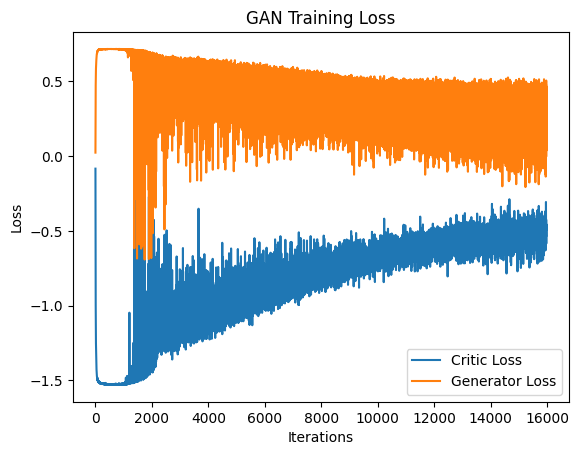

In [16]:
# Plot the losses
plt.plot(losses_critic, label='Critic Loss')
plt.plot(losses_gen, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.show()

In [ ]:
import shutil

# Define la ruta de la carpeta que quieres mover desde Google Colab
ruta_carpeta_colab = '/content/logs_WGAN'

# Define la ruta de destino en tu Google Drive
ruta_destino_drive = '/content/drive/My Drive/GANS/'

# Mueve la carpeta a tu Google Drive
shutil.move(ruta_carpeta_colab, ruta_destino_drive)